In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
from segmentation.keras_segmentation.models import fcn
from segmentation import keras_segmentation

In [3]:
from segmentation.keras_segmentation.models import all_models

In [4]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import dask_image.imread
import dask.array as da
from dask.distributed import Client
from collections import namedtuple
import pandas as pd
import numpy as np
import dask_image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from types import MethodType
import tensorflow as tf
import cv2

In [5]:
client = Client()
client

<Client: 'tcp://127.0.0.1:54180' processes=4 threads=16, memory=31.92 GiB>

# Preprocessing the data

In [4]:
images = dask_image.imread.imread('/home/v2thegreat/tensorflow_datasets/downloads/manual/leftImg/leftImg8bit/train/*/*.png', nframes=50)
labels = dask_image.imread.imread('/home/v2thegreat/tensorflow_datasets/downloads/manual/gtfine/gtFine/train/*/*_labelIds.png', nframes=50)
labels

dask.array<_map_read_frame, shape=(2975, 1024, 2048), dtype=uint8, chunksize=(1, 1024, 2048), chunktype=numpy.ndarray>

In [5]:
labels_metadata = [
    ('unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    ('ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    ('rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    ('out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    ('static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    ('dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    ('ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    ('road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    ('sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    ('parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    ('rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    ('building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    ('wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    ('fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    ('guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    ('bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    ('tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    ('pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    ('polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    ('traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    ('traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    ('vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    ('terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    ('sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    ('person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    ('rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    ('car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    ('truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    ('bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    ('caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    ('trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    ('train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    ('motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    ('bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    ('license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

label_metadata = pd.DataFrame(labels_metadata, columns=['name', 'id', 'trainId', 'category', 'catId', 'hasInstances', 'ignoreInEval', 'color'])
label_metadata[label_metadata['name'] == 'sidewalk']['id'].values

array([8])

In [6]:
def get_label_id(name):
    return label_metadata[label_metadata['name'] == name]['id'].values

def reduce_classes(labels, classes_to_keep = ['sidewalk', 'road'], label_metadata=label_metadata):
    new_labels = da.zeros_like(labels)
    label_dictionary = {}
    for ix, class_label in enumerate(classes_to_keep):

        mask = labels == get_label_id(class_label)
        new_labels += mask * (ix + 1) # 0 is reserved for ignored parameters
        label_dictionary[(ix + 1)] = class_label
        
    return new_labels, label_dictionary

In [7]:
classes_to_keep = ['sidewalk', 'road']

reduced_labels, label_dict = reduce_classes(labels, classes_to_keep=classes_to_keep)
reduced_labels.shape, label_dict

((2975, 1024, 2048), {1: 'sidewalk', 2: 'road'})

In [8]:
labels = xr.DataArray(labels, dims=['image_no', 'y', 'x'])
reduced_labels = xr.DataArray(reduced_labels, dims=['image_no', 'y', 'x'])
image_bands = xr.DataArray(images, dims=['image_no', 'y', 'x', 'color_band'])
image_bands

<xarray.DataArray '_map_read_frame-a600cafcf02544600aad21e14c0473d4' (image_no: 2975, y: 1024, x: 2048, color_band: 3)>
dask.array<_map_read_frame, shape=(2975, 1024, 2048, 3), dtype=uint8, chunksize=(1, 1024, 2048, 3), chunktype=numpy.ndarray>
Dimensions without coordinates: image_no, y, x, color_band

In [9]:
image_bands_ds = image_bands.assign_coords({'x': range(len(image_bands.x)), 'y': range(len(image_bands.y)), 'image_no': range(len(image_bands.image_no)), 'color_band': range(len(image_bands.color_band))}).to_dataset(name='images')
labels = labels.assign_coords({'x': range(len(labels.x)), 'y': range(len(labels.y)), 'image_no': range(len(labels.image_no))})
reduced_labels = reduced_labels.assign_coords({ 'y': range(len(reduced_labels.y)), 'x': range(len(reduced_labels.x)), 'image_no': range(len(reduced_labels.image_no))})

image_bands_ds['labels_reduced'] = reduced_labels.astype(np.uint8)
image_bands_ds['labels_full'] = labels
image_bands_ds

<xarray.Dataset>
Dimensions:         (x: 2048, y: 1024, image_no: 2975, color_band: 3)
Coordinates:
  * x               (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * y               (y) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * image_no        (image_no) int64 0 1 2 3 4 5 ... 2970 2971 2972 2973 2974
  * color_band      (color_band) int64 0 1 2
Data variables:
    images          (image_no, y, x, color_band) uint8 dask.array<chunksize=(1, 1024, 2048, 3), meta=np.ndarray>
    labels_reduced  (image_no, y, x) uint8 dask.array<chunksize=(1, 1024, 2048), meta=np.ndarray>
    labels_full     (image_no, y, x) uint8 dask.array<chunksize=(1, 1024, 2048), meta=np.ndarray>

In [10]:
n = 13
image_bands_ds.sel(image_no=n)['labels_reduced'].hvplot(invert=True, cmap='viridis', flip_yaxis=True) + image_bands_ds.sel(image_no=n)['labels_full'].hvplot(invert=True, cmap='viridis', flip_yaxis=True)

:Layout
   .Image.I  :Image   [y,x]   (labels_reduced)
   .Image.II :Image   [y,x]   (labels_full)

In [11]:
def save_nc(ds, filename):
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars}
    ds.to_netcdf(filename, encoding=encoding)

save_nc(image_bands_ds.isel(image_no=slice(100)), 'post_processed_data.nc')

# AI Training

## Next Steps:
 - Train an AI model on the data
   - Access the individual AI models that are present in the segmentation library
     - Modify the library to make it easier to access each of those models, instead of using the library

In [6]:
ds = xr.open_dataset('post_processed_data.nc', chunks='auto')
ds

C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _base: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:         (x: 2048, y: 1024, image_no: 99, color_band: 3)
Coordinates:
  * x               (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * y               (y) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * image_no        (image_no) int64 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * color_band      (color_band) int64 0 1 2
Data variables:
    images          (image_no, y, x, color_band) uint8 dask.array<chunksize=(99, 512, 1024, 2), meta=np.ndarray>
    labels_reduced  (image_no, y, x) uint8 dask.array<chunksize=(99, 512, 1024), meta=np.ndarray>
    labels_full     (image_no, y, x) uint8 dask.array<chunksize=(99, 512, 1024), meta=np.ndarray>

In [7]:
ds = ds.interp(coords={
    'x': range(0, 480),
    'y': range(0, 640),
}, method='nearest')
ds

<xarray.Dataset>
Dimensions:         (image_no: 99, color_band: 3, y: 640, x: 480)
Coordinates:
  * image_no        (image_no) int64 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * color_band      (color_band) int64 0 1 2
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 473 474 475 476 477 478 479
  * y               (y) int32 0 1 2 3 4 5 6 7 ... 633 634 635 636 637 638 639
Data variables:
    images          (image_no, y, x, color_band) float64 dask.array<chunksize=(99, 640, 480, 2), meta=np.ndarray>
    labels_reduced  (image_no, y, x) float64 dask.array<chunksize=(99, 640, 480), meta=np.ndarray>
    labels_full     (image_no, y, x) float64 dask.array<chunksize=(99, 640, 480), meta=np.ndarray>

In [8]:
X = ds['images'].compute().to_numpy()
y = ds['labels_reduced'].compute().to_numpy()

In [9]:
X.shape

(99, 640, 480, 3)

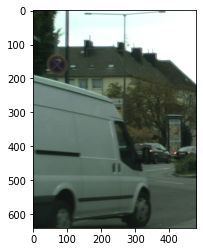

In [11]:
plt.imshow(X.astype(int)[50])

In [13]:
model = all_models.model_from_name['fcn_8_resnet50'](input_height=640, input_width=480, n_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(X, y, verbose=1, batch_size=8)

ValueError: in user code:

    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\ProgramData\Miniconda3\envs\world-construction-and-q-learning\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 640, 480) and (None, 316224, 3) are incompatible


## Defining the AI model

### Going with fcn-resnet

This is because according to [this readme](https://github.com/dusty-nv/jetson-inference/blob/master/docs/segnet-console-2.md), the jetson nano seems to achieve 48FPS given that configuration on cityscapes

In [6]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def get_resnet50_encoder(input_height=224,  input_width=224,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000, channels=3):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D((7, 7), data_format=IMAGE_ORDERING, name='avg_pool')(x)
    # f6 = x

    if pretrained == 'imagenet':
        weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x

encoder = get_resnet50_encoder(input_height=512,  input_width=512,
                         pretrained=False,
                         include_top=True,
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=3, channels=3)

encoder

2021-10-23 21:14:36.054946: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-23 21:14:36.079144: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_1')>,
 [<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'conv1')>,
  <KerasTensor: shape=(None, 128, 128, 256) dtype=float32 (created by layer 'lambda')>,
  <KerasTensor: shape=(None, 64, 64, 512) dtype=float32 (created by layer 'activation_21')>,
  <KerasTensor: shape=(None, 32, 32, 1024) dtype=float32 (created by layer 'activation_39')>,
  <KerasTensor: shape=(None, 16, 16, 2048) dtype=float32 (created by layer 'activation_48')>])

In [13]:
def get_segmentation_model(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        print(o_shape)
        o = (Reshape((output_height * output_width, -1)))(o)

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    return model

def crop(o1, o2, i):
    o_shape2 = Model(i, o2).output_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height2 = o_shape2[2]
        output_width2 = o_shape2[3]
    else:
        output_height2 = o_shape2[1]
        output_width2 = o_shape2[2]

    o_shape1 = Model(i, o1).output_shape
    if IMAGE_ORDERING == 'channels_first':
        output_height1 = o_shape1[2]
        output_width1 = o_shape1[3]
    else:
        output_height1 = o_shape1[1]
        output_width1 = o_shape1[2]

    cx = abs(output_width1 - output_width2)
    cy = abs(output_height2 - output_height1)

    if output_width1 > output_width2:
        o1 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o2)

    if output_height1 > output_height2:
        o1 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o2)

    return o1, o2


def fcn_8(n_classes,
          encoder=None, 
          input_height=416,
          input_width=608,
          channels=3):

    img_input, levels = encoder(input_height=input_height,  input_width=input_width, channels=channels, pretrained=False)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7, 7), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)
    o = (Conv2D(4096, (1, 1), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    o = (Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                data_format=IMAGE_ORDERING))(o)
    o = Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(
        2, 2), use_bias=False, data_format=IMAGE_ORDERING)(o)

    o2 = f4
    o2 = (Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                 data_format=IMAGE_ORDERING))(o2)

    o, o2 = crop(o, o2, img_input)

    o = Add()([o, o2])

    o = Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(
        2, 2), use_bias=False, data_format=IMAGE_ORDERING)(o)
    o2 = f3
    o2 = (Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                 data_format=IMAGE_ORDERING))(o2)
    o2, o = crop(o2, o, img_input)
    o = Add( name="seg_feats" )([o2, o])

    o = Conv2DTranspose(n_classes, kernel_size=(16, 16),  strides=(
        8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    print(o)
    model = get_segmentation_model(img_input, o)
    model.model_name = "fcn_8"
    return model

model = fcn_8(3, input_height=len(ds.y), input_width=len(ds.x), encoder=get_resnet50_encoder)
model

KerasTensor(type_spec=TensorSpec(shape=(None, 520, 520, 3), dtype=tf.float32, name=None), name='conv2d_transpose_17/conv2d_transpose:0', description="created by layer 'conv2d_transpose_17'")
(None, 520, 520, 3)


In [12]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 518, 518, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
epochs = 100
hist = model.fit(X, y, epochs=epochs, batch_size=8, verbose=1)
hist

2021-10-23 21:18:52.589381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


ValueError: in user code:

    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:862 train_function  *
        return step_function(self, iterator)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:852 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 run_step  **
        outputs = model.train_step(data)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:803 train_step
        loss = self.compiled_loss(
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1679 categorical_crossentropy
        return backend.categorical_crossentropy(
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4875 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/v2thegreat/miniconda3/envs/sidewalk_detection/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 512, 512) and (None, 270400, 3) are incompatible


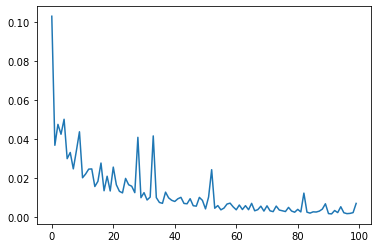

In [26]:
plt.plot(hist.history['loss'])